In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import pickle


import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("E:/research/Spacematch/formal research/feedback_89.csv") #import the data-points
df.head(100) 


,user_id,place_id,sensations_temperature,preferences_temperature,clothing_level,indoor_temp,indoor_humidity,outdoor_temp,outdoor_humidity,created_at,Time
0,89,8939,4,2,1,76.860000,39.820000,64.94,84.273097,9/27/2021 14:33,10
1,89,8939,4,2,1,76.950000,39.810000,64.94,84.273097,9/27/2021 14:39,10
2,89,8921,3,3,2,69.390000,48.940000,64.94,84.273097,9/27/2021 14:51,10
3,89,8921,3,3,2,69.480000,48.900000,64.94,84.273097,9/27/2021 14:57,10
4,89,8935,4,2,2,75.270000,40.210000,64.94,84.273097,9/27/2021 15:08,11
...,...,...,...,...,...,...,...,...,...,...,...
69,89,8921,3,3,1,68.944988,50.718111,66.02,96.315122,10/8/2021 14:03,10
70,89,8921,3,3,1,69.232992,50.380988,66.02,96.315122,10/8/2021 14:11,10
71,89,8935,3,3,1,74.625006,41.906231,66.02,96.315122,10/8/2021 14:18,10
72,89,8935,4,2,1,75.092979,41.799801,66.02,100.000000,10/8/2021 14:23,10


<AxesSubplot:xlabel='sensations_temperature', ylabel='indoor_temp'>

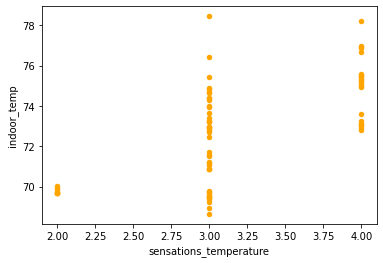

In [3]:
Scatter_plot = df.plot.scatter(x = "sensations_temperature", y = "indoor_temp", c = 'orange')
Scatter_plot

In [4]:
y = df.sensations_temperature
X = df.drop(["user_id","place_id","created_at", "sensations_temperature","preferences_temperature"], axis = 1)  #Get X and y

In [5]:
y.value_counts()

3    44
4    22
2     8
Name: sensations_temperature, dtype: int64

In [28]:
rt_data = pd.read_csv("E:/research/Spacematch/formal research/real_time_room_data.csv")
rt_data = rt_data.drop(["room_id"], axis = 1)
X = X.append(rt_data)

def createNewTime(row):
    if row['Time'] <= 12:
        return 1
    else:
        return 2
    
X['New Time'] = X.apply(createNewTime, axis=1)
X = X.drop(['Time'], axis = 1)
rt_data = X.iloc[-4:]
X = X.iloc[:74]

In [29]:
X.head(10)

,clothing_level,indoor_temp,indoor_humidity,outdoor_temp,outdoor_humidity,New Time
0,1,76.86,39.82,64.94,84.273097,1
1,1,76.95,39.81,64.94,84.273097,1
2,2,69.39,48.94,64.94,84.273097,1
3,2,69.48,48.90,64.94,84.273097,1
4,2,75.27,40.21,64.94,84.273097,1
5,2,75.43,40.13,64.94,84.273097,1
6,2,73.19,42.66,69.08,70.285014,1
7,2,73.23,42.64,69.08,70.285014,1
8,2,73.23,42.62,69.08,70.285014,1
9,1,78.22,38.48,82.04,50.870173,2


In [30]:
param_test = {"n_estimators"     :range(1,50,1),
              "max_features"     :range(1,6,1),
              "max_depth"        :range(1,6,1),
                  } # Optimize the parameters

cv_param = []
estimator_param = []
feature_param = []
depth_param = []
accuracy_param = []
loo_accuracy_param = []

room_1_neutral = []
room_2_neutral = []
room_3_neutral = []
room_4_neutral = []

clothing_level_im = []
indoor_temp_im = []
indoor_hum_im = []
outdoor_temp_im = []
outdoor_hum_im = []
Time_im = []

for i in range (2,7,1):
    gsearch = GridSearchCV(estimator = RandomForestClassifier(random_state = 10, class_weight = "balanced"),
                param_grid = param_test, cv = i)
    gsearch.fit(X, y)
    estimator     = gsearch.best_params_["n_estimators"]
    feature       = gsearch.best_params_["max_features"]
    depth         = gsearch.best_params_["max_depth"]
    cv_param.append(i)
    estimator_param.append(estimator)
    feature_param.append(feature)
    depth_param.append(depth)
    accuracy_param.append(gsearch.best_score_)

#     para = (estimator, feature, depth, gsearch.best_score_)

    loo = LeaveOneOut() # test the accuracy with leaveoneout
    y_true = []
    y_pred = []
    for train_index, test_index in loo.split(X): # Split in X
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        rfc = RandomForestClassifier(n_estimators = estimator, 
                                    max_features = feature,                                
                                    max_depth = depth,
                                    class_weight = "balanced",
                                    random_state = 10)
        rfc = rfc.fit(X_train, y_train) # train model
        predict_y = rfc.predict(X_test)
        y_true.append(y_test[0])
        y_pred.append(predict_y[0])
    accuracy = accuracy_score(y_true, y_pred)
    loo_accuracy_param.append(accuracy)
    
#     print("accuracy is:", accuracy)

    rfc = RandomForestClassifier(n_estimators = estimator,  #predict the probability of different feels in different rooms
                                max_features = feature,                                
                                max_depth = depth,
                                class_weight = "balanced",
                                random_state = 10)
    rfc = rfc.fit(X, y)
    
#     print(rfc.predict(rt_data))

    
    rt_prepro = rfc.predict_proba(rt_data)
    room_1_neutral.append(rt_prepro[0][1])
    room_2_neutral.append(rt_prepro[1][1])
    room_3_neutral.append(rt_prepro[2][1])
    room_4_neutral.append(rt_prepro[3][1])
    
#     print("probability : \n", rt_prepro)

    rt_feature = rfc.feature_importances_
    clothing_level_im.append(rt_feature[0])
    indoor_temp_im.append(rt_feature[0])
    indoor_hum_im.append(rt_feature[1])
    outdoor_temp_im.append(rt_feature[2])
    outdoor_hum_im.append(rt_feature[3])
    Time_im.append(rt_feature[4])

#     print("feature name:", rt_data.columns.values.tolist())

In [31]:
# df = pd.DataFrame(list(zip(lst1, lst2)), columns =['key', 'value']) 
result = pd.DataFrame(list(zip(cv_param, estimator_param,feature_param, depth_param, accuracy_param, loo_accuracy_param, 
                               room_1_neutral, room_2_neutral, room_3_neutral, room_4_neutral, 
                               clothing_level_im, indoor_temp_im, indoor_hum_im, outdoor_temp_im, outdoor_hum_im, Time_im)),
                      columns = ['cv', 'estimator', 'feature', 'depth', 'accuracy', 'loo_accuracy', 
                                 'room_1', 'room_2', 'room_3', 'room_4','clothing_level_im', 'indoor_temp', 'indoor_hum',
                                 'outdoor_temp', 'outdoor_hum', 'Time'])       

In [32]:
result.to_csv('E:/research/Spacematch/formal research/feedback_89_result_rf.csv')

In [33]:
# param_test = {"n_estimators"     :range(1,50,1),
#               "max_features"     :range(1,7,1),
#               "max_depth"        :range(1,7,1),
#               } # Optimize the parameters
# gsearch = GridSearchCV(estimator = RandomForestClassifier(random_state = 10, class_weight = "balanced"),
#             param_grid = param_test, cv = 8)
# gsearch.fit(X, y)

In [34]:
# estimator     = gsearch.best_params_["n_estimators"]
# feature       = gsearch.best_params_["max_features"]
# depth         = gsearch.best_params_["max_depth"]
# para = (estimator, feature, depth, gsearch.best_score_)
# print(para)

In [35]:
# loo = LeaveOneOut() # test the accuracy with leaveoneout
# y_true = []
# y_pred = []
# for train_index, test_index in loo.split(X): # Split in X
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = y.values[train_index], y.values[test_index]
#     rfc = RandomForestClassifier(n_estimators = estimator, 
#                                 max_features = feature,
#                                 max_depth = depth,
#                                 class_weight = "balanced",
#                                 random_state = 10)
#     rfc = rfc.fit(X_train, y_train) # train model
#     predict_y = rfc.predict(X_test)
#     y_true.append(y_test[0])
#     y_pred.append(predict_y[0])
# print(y_true)
# print(y_pred)
# accuracy = accuracy_score(y_true, y_pred)
# print("accuracy is:", accuracy)

In [36]:
# import the realtime room data
# rt_data = pd.read_csv("E:/research/Spacematch/formal research/real_time_room_data.csv")
# print(rt_data)
# rt_data = rt_data.drop(["room_id"], axis = 1)
# rt_data.head()

In [37]:
# rfc = RandomForestClassifier(n_estimators = estimator,  #predict the probability of different feels in different rooms
#                                 max_features = feature, 
#                                 min_samples_split = 2, 
#                                 max_depth = depth,
#                                 min_samples_leaf = 1,
#                                 criterion = "gini",
#                                 random_state = 10)
# rfc = rfc.fit(X, y)

In [38]:
# filename = 'test_model.sav'
# pickle.dump(rfc, open(filename, 'wb'))

In [39]:
# print(rfc.predict(rt_data))
# rt_prepro = rfc.predict_proba(rt_data)
# print("probability : \n", rt_prepro)
# print("feature importance:", rfc.feature_importances_)
# print("feature name:", rt_data.columns.values.tolist())